In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
figwidth=3.3
sns.set()
sns.set_palette('colorblind')
sns.set_context('paper', font_scale=0.75)
sns.set_style("whitegrid")
figsize=(figwidth, figwidth/1.5)

def removeprefix(self: str, prefix: str, /) -> str:
    if self.startswith(prefix):
        return self[len(prefix):]
    else:
        return self[:]
%config InlineBackend.figure_format = 'retina'


In [2]:
nepisodes = 200000
tot = []
for name, cond in [("CMA-ES","cmafixed"), ("PPO-MLP", "ppobiglr"), ("PPO-DEEP", "../../paperrun3/bignetfastredo/")]:
    print(name)
    path = f"logs/paperrun2/e{nepisodes}/{cond}/"

    shortname = ''.join(removeprefix(path, 'logs/').split('/'))
    print(shortname)
    figdir = "figures/paperrun2e200000/"
    os.makedirs(figdir, exist_ok=True)

    a = pd.read_csv(path+ "/postmortem.csv.gz")
    aout = a.set_index(["p", "run_id"])
    op = a.groupby(["p", "run_id"])["inv"].std()
    aout["inv_std"] = op
    op = a.groupby(["p", "run_id"])["inv"].mean()
    aout["inv_mean"] = op
    alldf = pd.read_pickle(path + "/sumup.df.pkl")
    tb = alldf.query("episode_bin_right == @nepisodes")[["trial_id", "episode_reward_mean", "episode_bin_right"]]
    tb = tb.groupby(["trial_id"], as_index=False).mean()
    #tb.query("p == 1").sort_values("episode_reward_mean")

    a = aout.reset_index().merge(tb, on="trial_id")
    a["Algorithm"] = name
    print(a.head())
    tot.append(a.copy())
a =  pd.concat(tot)

CMA-ES
paperrun2e200000cmafixed
     p  run_id  Unnamed: 0  inv  other  accept     trial_id  good_site_prob  \
0  0.1      11           0  9.5    0.0       0  c6304_00011             0.1   
1  0.1      11           1  9.5    0.0       0  c6304_00011             0.1   
2  0.1      11           2  9.5    0.0       0  c6304_00011             0.1   
3  0.1      11           3  9.5    0.0       0  c6304_00011             0.1   
4  0.1      11           4  9.5    0.0       0  c6304_00011             0.1   

                                     checkpoint_path  inv_std  inv_mean  \
0  /Users/paulecoffet/Documents/isir/These/data/R...      0.0       9.5   
1  /Users/paulecoffet/Documents/isir/These/data/R...      0.0       9.5   
2  /Users/paulecoffet/Documents/isir/These/data/R...      0.0       9.5   
3  /Users/paulecoffet/Documents/isir/These/data/R...      0.0       9.5   
4  /Users/paulecoffet/Documents/isir/These/data/R...      0.0       9.5   

   episode_reward_mean  episode_bin_right 

In [3]:
def pltvline(data, x, color="g", **kwargs):
    plt.axvline(data[x].mean(), color=color, **kwargs)

def pltvspan(data, mean, std, color="g"):
    mean = data[mean].mean()
    std = data[std].mean()
    plt.axvspan(mean - 2 * std, mean + 2 * std, color=color, alpha=0.2)

[20, 17, 21, 19]


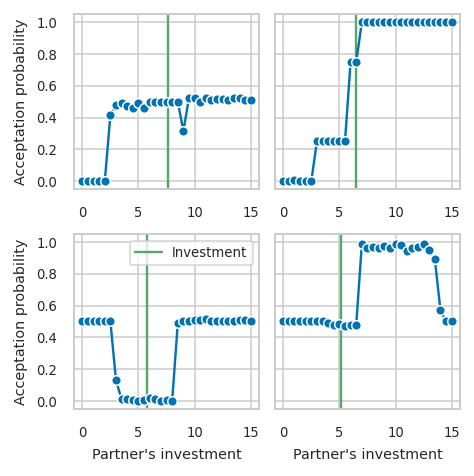

In [4]:
x = 1
p = 0.1
showrange = 2
bestworst = a.query("p == @p").sort_values("episode_reward_mean")["run_id"].unique()
worst = bestworst[:showrange]
best = bestworst[-showrange:]
a.loc[(a["p"] == p) & (a["run_id"].isin(worst)), "quality"] = "worst"
a.loc[(a["p"] == p) & (a["run_id"].isin(best)), "quality"] = "best"
a.loc[(a["p"] == p) & (a["run_id"].isin([worst[0], best[0]])), "rankqual"] = 1
a.loc[(a["p"] == p) & (a["run_id"].isin([worst[1], best[1]])), "rankqual"] = 2

bestworst = list(bestworst[0:showrange]) + list(bestworst[-showrange:])
print(bestworst)
g = sns.FacetGrid(data=a.query("p==@p and run_id in @bestworst"),
                  col="rankqual", row="quality", sharex=False, height=figwidth/(1*2),
                  row_order=["best", "worst"], despine=False, legend_out=False)
g.map_dataframe(pltvspan, mean="inv", std="inv_std")
g.map_dataframe(pltvline, x="inv", color="g", label="Investment")
g.map_dataframe(sns.lineplot, x="other", y="accept", markers=True, style="p", label=None, ci=None)
g.set_axis_labels("Partner's investment", "Acceptation probability")
g.set_titles("")
(han, _), (lab, _) = g.axes[1,x].get_legend_handles_labels()
l = g.axes[1, 0].legend((han,),(lab,))
g.tight_layout()
g.savefig(figdir + f"/postmortem_{p}_no_label.pdf")

In [5]:
a.groupby(["p"])["run_id"].nunique()

p
0.1    24
0.2    24
0.5    24
1.0    24
Name: run_id, dtype: int64

In [6]:
import matplotlib as mpl
from copy import copy
from seaborn import utils

def set_titles(self, template=None, row_template=None, col_template=None, row_args=None, col_args=None,
                   **kwargs):
        """Draw titles either above each facet or on the grid margins.

        Parameters
        ----------
        template : string
            Template for all titles with the formatting keys {col_var} and
            {col_name} (if using a `col` faceting variable) and/or {row_var}
            and {row_name} (if using a `row` faceting variable).
        row_template:
            Template for the row variable when titles are drawn on the grid
            margins. Must have {row_var} and {row_name} formatting keys.
        col_template:
            Template for the row variable when titles are drawn on the grid
            margins. Must have {col_var} and {col_name} formatting keys.

        Returns
        -------
        self: object
            Returns self.

        """
        args = dict(row_var=self._row_var, col_var=self._col_var)
        kwargs["size"] = kwargs.pop("size", mpl.rcParams["axes.labelsize"])

        if row_args is None:
            row_args = {}
        if col_args is None:
            col_args = {}
        # Establish default templates
        if row_template is None:
            row_template = "{row_var} = {row_name}"
        if col_template is None:
            col_template = "{col_var} = {col_name}"
        if template is None:
            if self._row_var is None:
                template = col_template
            elif self._col_var is None:
                template = row_template
            else:
                template = " | ".join([row_template, col_template])

        row_template = utils.to_utf8(row_template)
        col_template = utils.to_utf8(col_template)
        template = utils.to_utf8(template)

        if self._margin_titles:

            # Remove any existing title texts
            for text in self._margin_titles_texts:
                text.remove()
            self._margin_titles_texts = []
            
            true_row_args = copy(kwargs)
            true_row_args.update(row_args)

            if self.row_names is not None:
                # Draw the row titles on the right edge of the grid
                for i, row_name in enumerate(self.row_names):
                    ax = self.axes[i, -1]
                    args.update(dict(row_name=row_name))
                    title = row_template.format(**args)
                    text = ax.annotate(
                        title, xy=(1.02, .5), xycoords="axes fraction",
                        rotation=270, ha="left", va="center", **true_row_args
                    )
                    self._margin_titles_texts.append(text)

            if self.col_names is not None:
                # Draw the column titles  as normal titles
                for j, col_name in enumerate(self.col_names):
                    args.update(dict(col_name=col_name))
                    title = col_template.format(**args)
                    self.axes[0, j].set_title(title, **col_args, **kwargs)

            return self

        # Otherwise title each facet with all the necessary information
        if (self._row_var is not None) and (self._col_var is not None):
            for i, row_name in enumerate(self.row_names):
                for j, col_name in enumerate(self.col_names):
                    args.update(dict(row_name=row_name, col_name=col_name))
                    title = template.format(**args)
                    self.axes[i, j].set_title(title, **kwargs)
        elif self.row_names is not None and len(self.row_names):
            for i, row_name in enumerate(self.row_names):
                args.update(dict(row_name=row_name))
                title = template.format(**args)
                self.axes[i, 0].set_title(title, **kwargs)
        elif self.col_names is not None and len(self.col_names):
            for i, col_name in enumerate(self.col_names):
                args.update(dict(col_name=col_name))
                title = template.format(**args)
                # Index the flat array so col_wrap works
                self.axes.flat[i].set_title(title, **kwargs)
        return self

('CMA-ES', 0.1)
('CMA-ES', 0.2)
('CMA-ES', 0.5)
('CMA-ES', 1.0)
('PPO-DEEP', 0.1)
('PPO-DEEP', 0.2)
('PPO-DEEP', 0.5)
('PPO-DEEP', 1.0)
('PPO-MLP', 0.1)
('PPO-MLP', 0.2)
('PPO-MLP', 0.5)
('PPO-MLP', 1.0)


/home/ecoffet/anaconda3/envs/rlcoop/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/home/ecoffet/anaconda3/envs/rlcoop/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


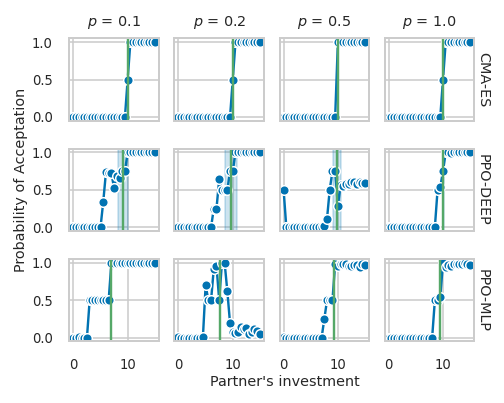

In [90]:
x = 1
showrange = 1
alls = []
for n, g in a.groupby(["Algorithm","p"]):
    print(n)
    g = g.copy()
    bestworst = g.sort_values("episode_reward_mean")["run_id"].unique()
    worst = bestworst[:showrange]
    best = bestworst[-showrange:]
    g.loc[(g["run_id"].isin(worst)), "quality"] = "Worst"
    g.loc[(g["run_id"].isin(best)), "quality"] = "Best"
    out = g.query("quality == 'Worst' or quality == 'Best'").copy()
    alls.append(out)
    
na = pd.concat(alls)

height = 0.9
aspect = 3.3 / (4 * height)

bestworst = list(bestworst[0:showrange]) + list(bestworst[-showrange:])
g = sns.FacetGrid(data=na.query("quality == 'Best'"),
                  col="p", row="Algorithm", sharex=True, height=height, aspect=aspect,
                  row_order=["CMA-ES", "PPO-DEEP", "PPO-MLP"], despine=False, legend_out=False, margin_titles=True)
g.map_dataframe(pltvspan, mean="inv", std="inv_std")
g.map_dataframe(sns.lineplot, x="other", y="accept", markers=True, style="p", label=None, ci=None)
g.map_dataframe(pltvline, x="inv", color="g", label="$x_\\bullet$")
g.set_axis_labels("", "")
set_titles(g, col_template="$p$ = {col_name}", row_template="{row_name}")#, row_args={"fontweight": "bold", "size": 8})
#g.fig.suptitle("PPO", size=11)
g.fig.subplots_adjust(top=1, bottom=0, left=0, right=1)
#(_, han), (_, lab) = g.axes[1,x].get_legend_handles_labels()

g.fig.text(-0.03, 0.30, "Probability of Acceptation", rotation=90, multialignment="center", label=None)
g.fig.text(0.54, 0, "Partner's investment", horizontalalignment="center", label=None)
#l = g.axes[1, 0].legend((han,),(lab,), loc="lower left")
g.tight_layout()
g.savefig(figdir + f"/postmortem_{p}_ppocma.pdf")

[20, 17, 21, 19]


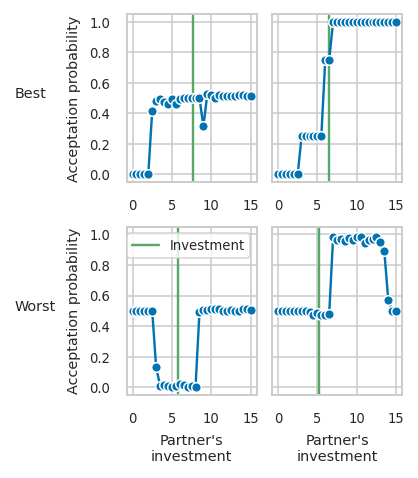

In [8]:
showrange = 2
bestworst = a.query("p == @p").sort_values("episode_reward_mean")["run_id"].unique()
worst = bestworst[:showrange]
best = bestworst[-showrange:]
a.loc[(a["p"] == p) & (a["run_id"].isin(worst)), "quality"] = "worst"
a.loc[(a["p"] == p) & (a["run_id"].isin(best)), "quality"] = "best"
a.loc[(a["p"] == p) & (a["run_id"].isin([worst[0], best[0]])), "rankqual"] = 1
a.loc[(a["p"] == p) & (a["run_id"].isin([worst[1], best[1]])), "rankqual"] = 2

bestworst = list(bestworst[0:showrange]) + list(bestworst[-showrange:])
print(bestworst)
g = sns.FacetGrid(data=a.query("p==@p and run_id in @bestworst"),
                  col="rankqual", row="quality", sharex=False, height=figwidth/(1*2),
                  row_order=["best", "worst"], despine=False, legend_out=False)
g.map_dataframe(pltvspan, mean="inv", std="inv_std")
g.map_dataframe(pltvline, x="inv", color="g", label="Investment")
g.map_dataframe(sns.lineplot, x="other", y="accept", markers=True, style="p", ci=None)
g.set_axis_labels("Partner's\ninvestment", "Acceptation probability")
for ax in g.axes.flat:
    ax.set_xticks([0, 5, 10, 15])
g.set_titles("")
g.axes[0, 0].text(-15, 0.5, "Best")
g.axes[1, 0].text(-15, 0.5, "Worst")
(han, _), (lab, _) = g.axes[1,x].get_legend_handles_labels()
l = g.axes[1, 0].legend((han,),(lab,))

g.tight_layout()
g.savefig(figdir + f"/postmortem_{p}.pdf")

[6, 8, 22, 20]


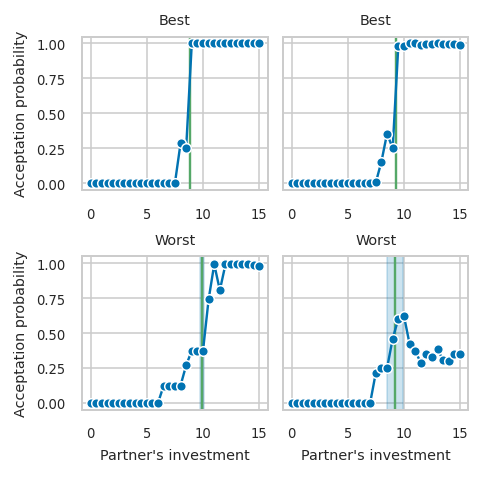

In [9]:
p = 1.0
showrange = 2
bestworst = a.query("p == @p").sort_values("episode_reward_mean")["run_id"].unique()
worst = bestworst[:showrange]
best = bestworst[-showrange:]
a.loc[(a["p"] == p) & (a["run_id"].isin(worst)), "quality"] = "Worst"
a.loc[(a["p"] == p) & (a["run_id"].isin(best)), "quality"] = "Best"
a.loc[(a["p"] == p) & (a["run_id"].isin([worst[0], best[0]])), "rankqual"] = 1
a.loc[(a["p"] == p) & (a["run_id"].isin([worst[1], best[1]])), "rankqual"] = 2

bestworst = list(bestworst[0:showrange]) + list(bestworst[-showrange:])
print(bestworst)
g = sns.FacetGrid(data=a.query("p==@p and run_id in @bestworst"),
                  col="rankqual", row="quality", sharex=False, height=figwidth/(1*2),
                  row_order=["Best", "Worst"], despine=False)
g.map_dataframe(pltvspan, mean="inv", std="inv_std")
g.map_dataframe(pltvline, x="inv", color="g")
g.map_dataframe(sns.lineplot, x="other", y="accept", markers=True, style="p", ci=None)
g.set_axis_labels("Partner's investment", "Acceptation probability")
g.set_titles("{row_name}")

g.tight_layout()
g.savefig(figdir + f"/postmortem_{p}_label_top.pdf")

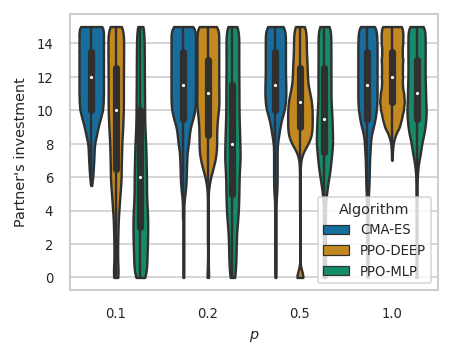

In [10]:
plt.figure(figsize=(figwidth, figwidth/1.3))
sns.violinplot(data=a.query("accept == 1"), hue="Algorithm", x="p", y="other", cut=0, hue_order=["CMA-ES", "PPO-DEEP", "PPO-MLP"])
plt.ylabel("Partner's investment")
plt.xlabel("$p$")
plt.savefig("accept_violin.pdf")

In [11]:
[int(x*255) for x  in sns.color_palette()[1]]

[222, 143, 5]

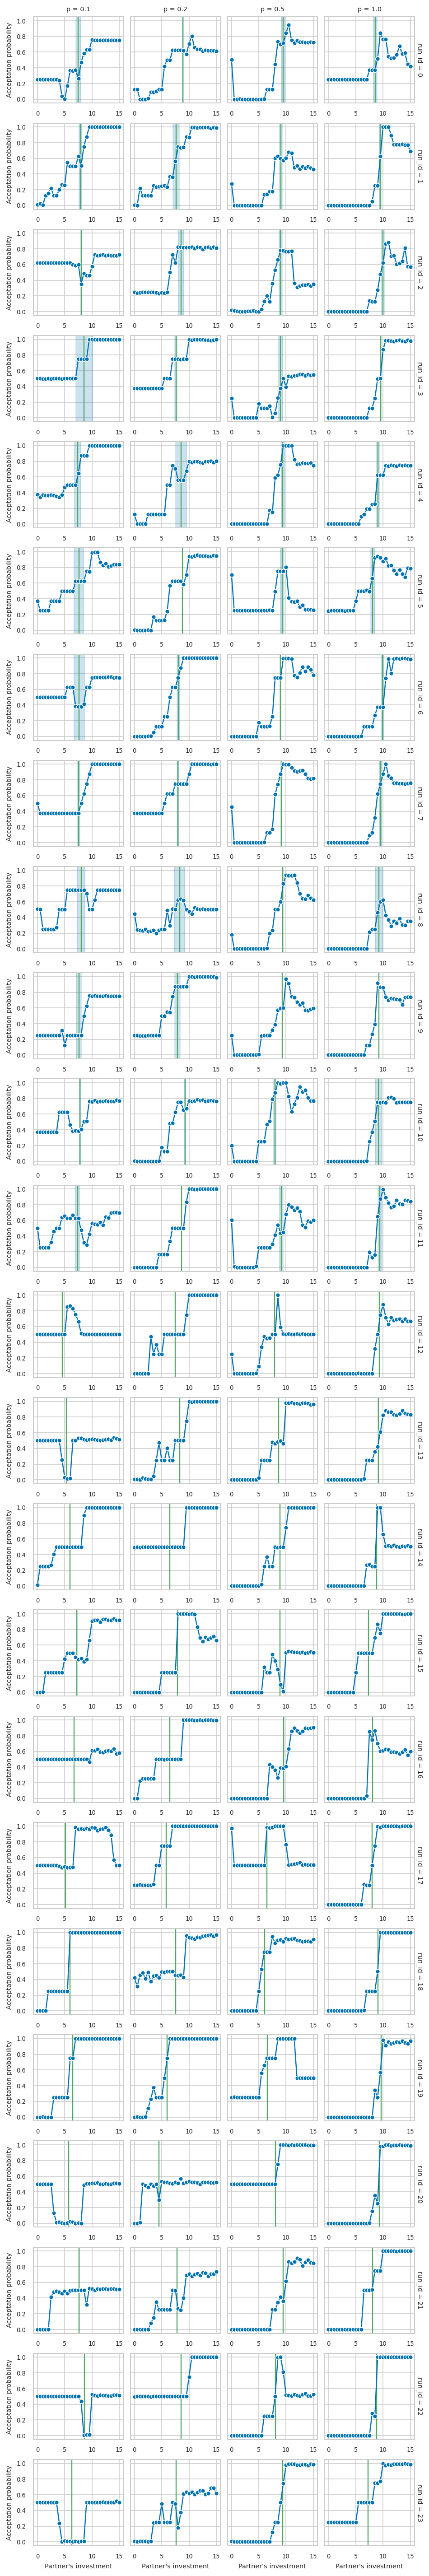

In [12]:
g = sns.FacetGrid(data=a,
                  row="run_id", col="p", sharex=False, margin_titles=True, height=figwidth/(1*2), despine=False)
g.map_dataframe(pltvspan, mean="inv", std="inv_std")
g.map_dataframe(pltvline, x="inv", color="g")
g.map_dataframe(sns.lineplot, x="other", y="accept", markers=True, style="p", ci=None)
g.set_axis_labels("Partner's investment", "Acceptation probability")
g.tight_layout()
g.savefig(figdir + f"/postmortem_all_all.pdf")

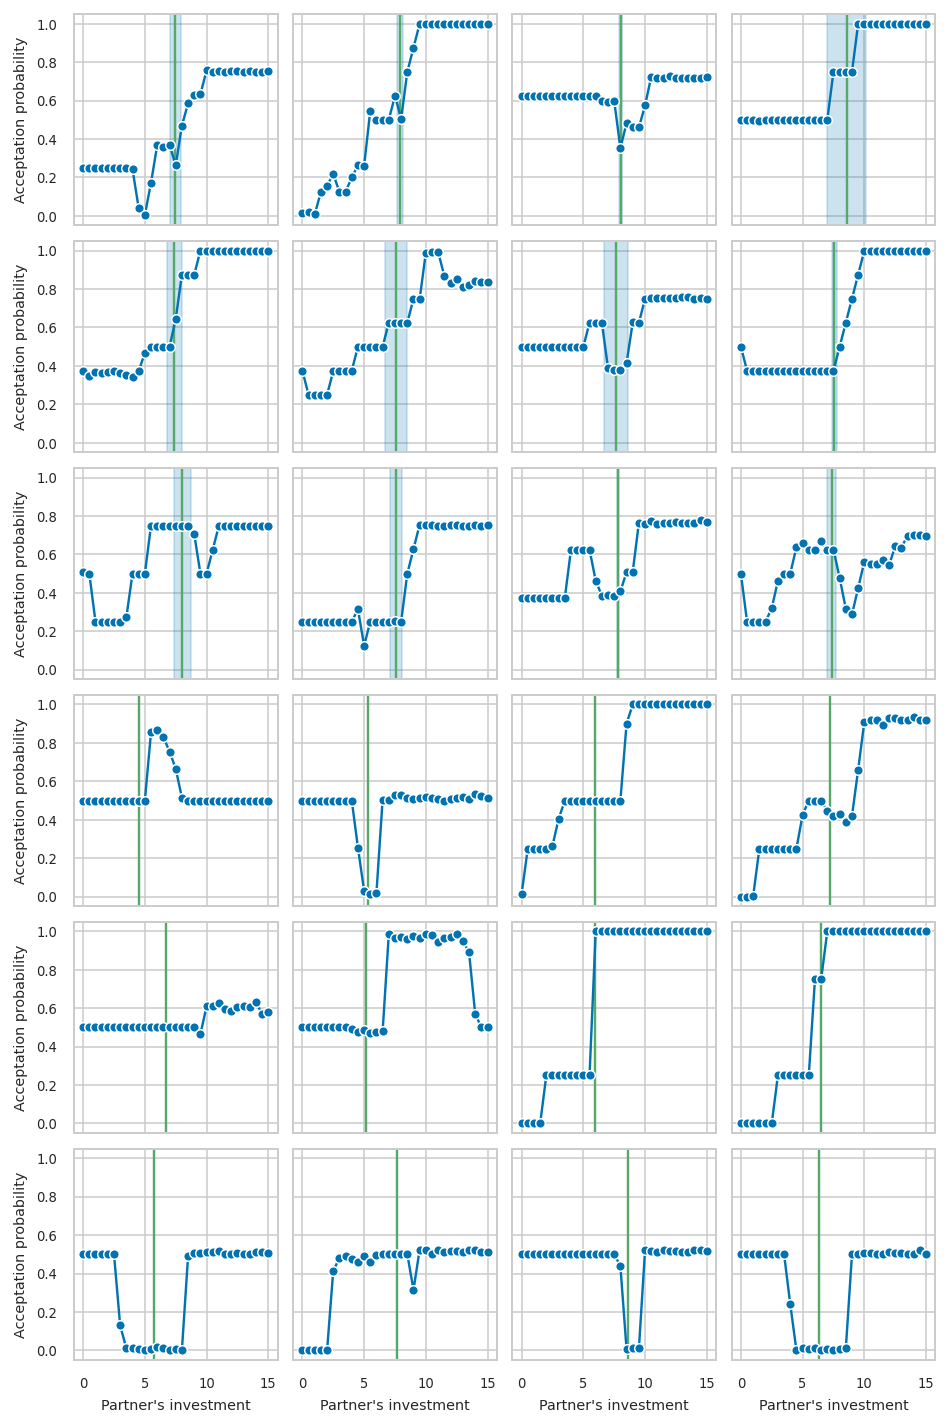

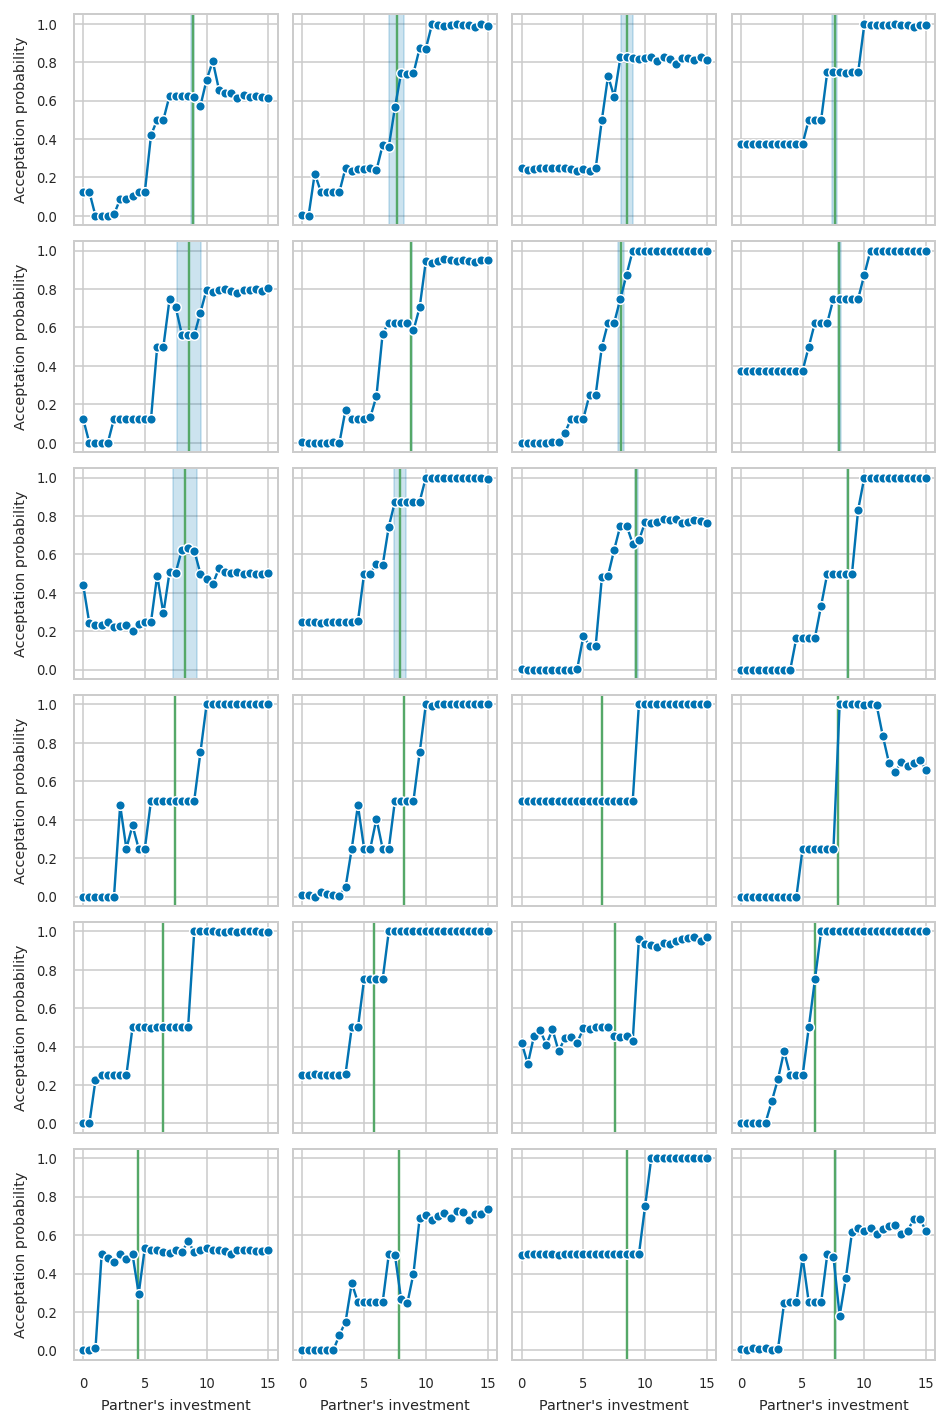

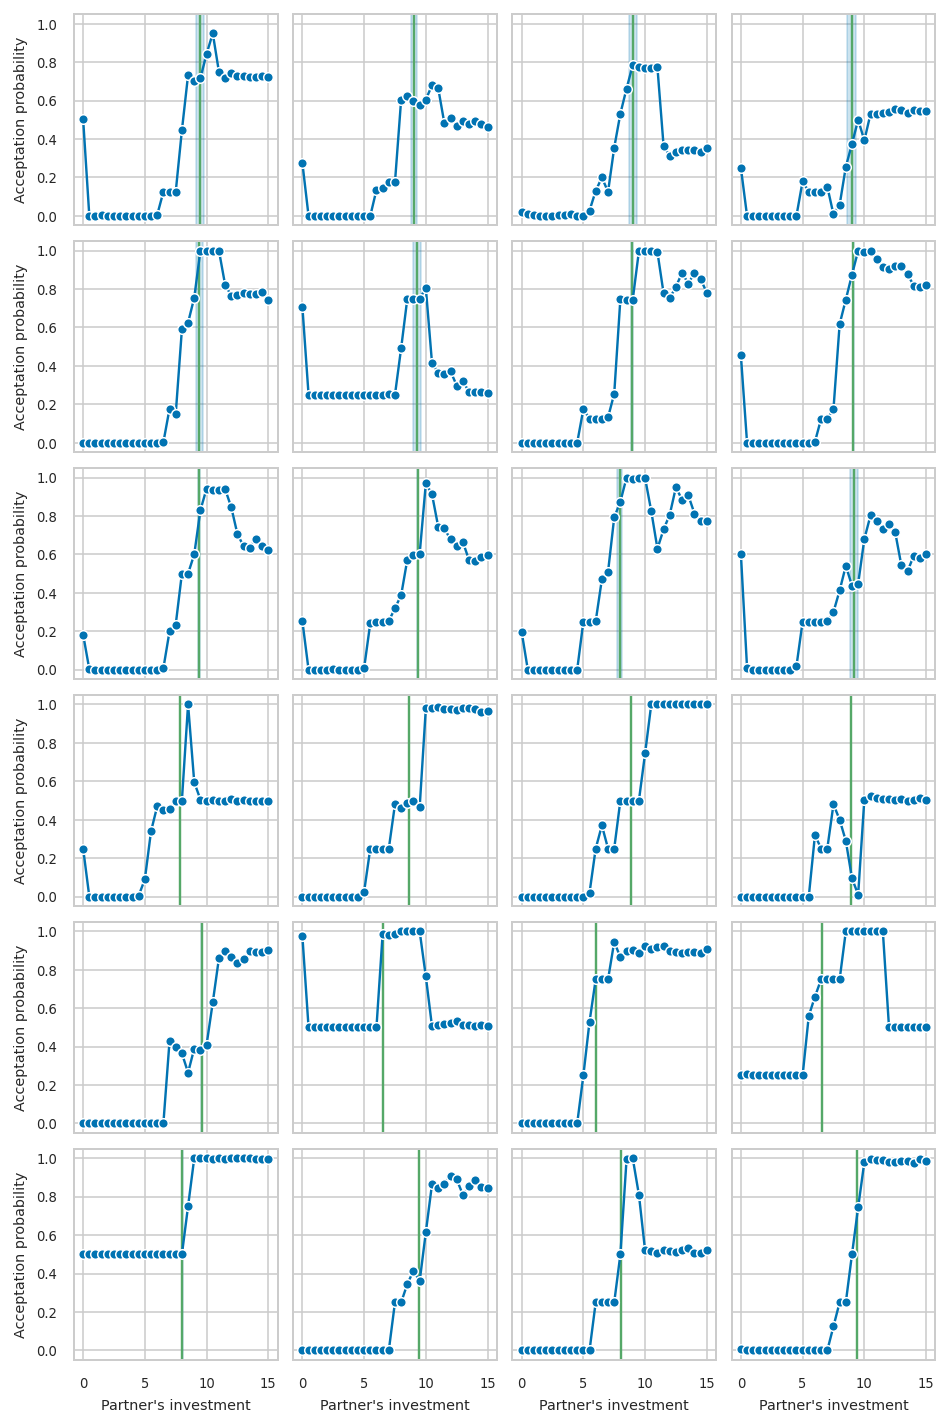

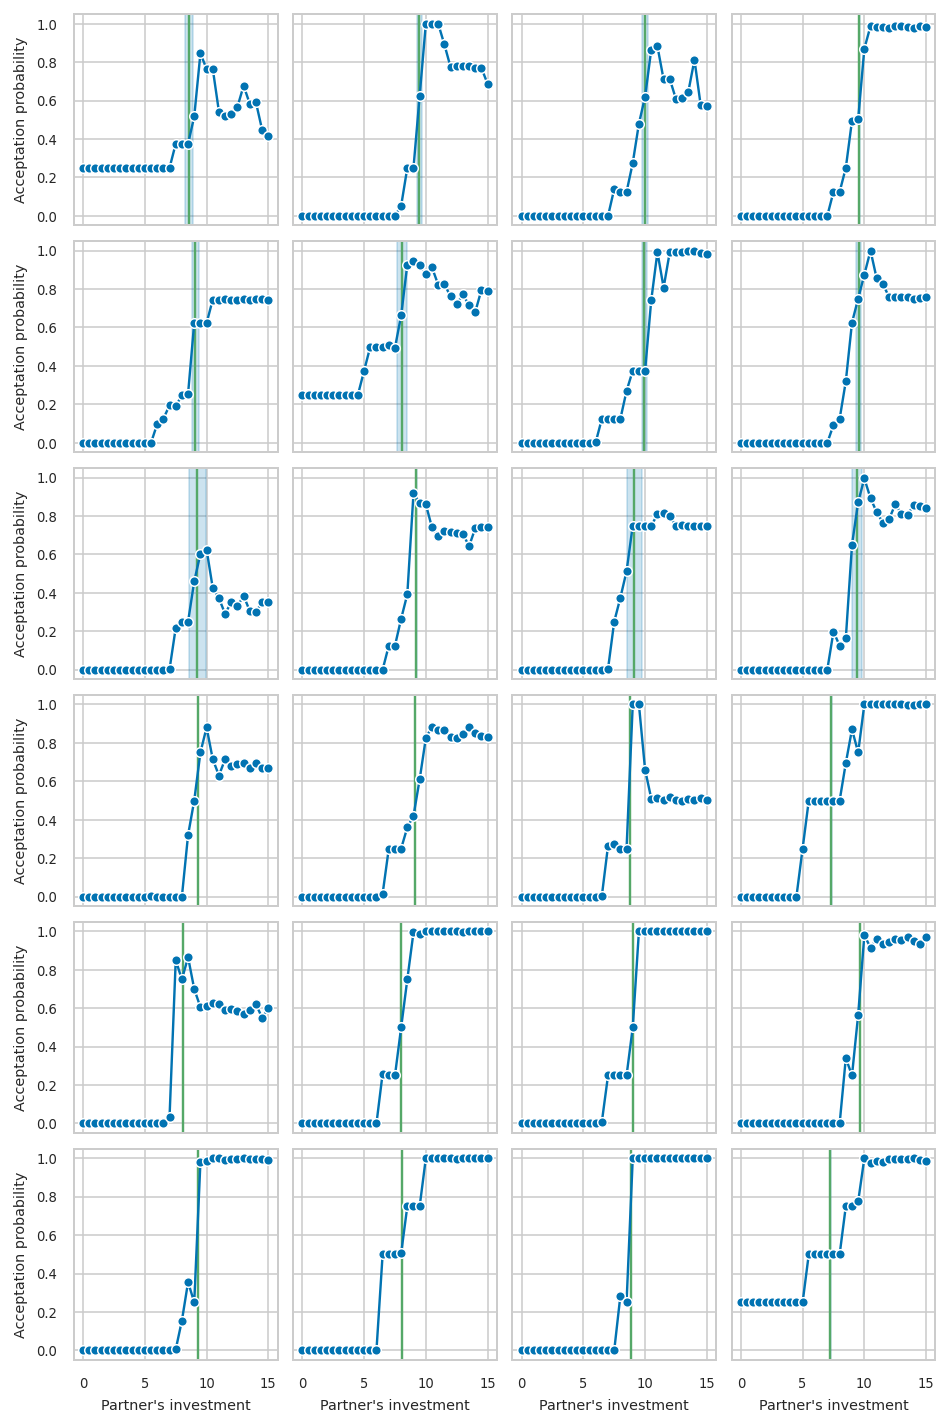

In [13]:
for p in [0.1, 0.2, 0.5, 1]:
    g = sns.FacetGrid(data=a.query("p == @p"),
                      col="run_id", col_wrap=4, margin_titles=True, height=figwidth/(1*2), despine=False)
    g.map_dataframe(pltvspan, mean="inv", std="inv_std")
    g.map_dataframe(pltvline, x="inv", color="g")
    g.map_dataframe(sns.lineplot, x="other", y="accept", markers=True, style="p", ci=None)
    g.set_axis_labels("Partner's investment", "Acceptation probability")
    g.set_titles("", "", "")
    g.tight_layout()
    g.savefig(figdir + f"/postmortem_all_{p}.pdf")